<a href="https://colab.research.google.com/github/g185/AMLrepository/blob/main/RecipeNet/AML_Project_Gabriele.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#***Download and unzip Dataset***


*   Create folders
*   Download Recipe 5K + Annotations in drive
*   Unzip files in folder



In [ ]:
#Create folders for models and datasets
!mkdir "/content/drive/My Drive/RecipeNet" 
!mkdir "/content/drive/My Drive/RecipeNet/datasets" 
!mkdir "/content/drive/My Drive/RecipeNet/datasets/download" 
!mkdir "/content/drive/My Drive/RecipeNet/datasets/extracted" 
!mkdir "/content/drive/My Drive/RecipeNet/datasets/preprocessed" 
!mkdir "/content/drive/My Drive/RecipeNet/model" 

#Scarica dataset
#Trascina i 3 zip

#Unzip
"""
!unzip "/content/drive/My Drive/RecipeNet/datasets/download/Recipes5k.zip" -d "/content/drive/My Drive/RecipeNet/datasets/extracted"
!unzip "/content/drive/My Drive/RecipeNet/datasets/download/archive.zip" -d "/content/drive/My Drive/RecipeNet/datasets/extracted"
!unzip "/content/drive/My Drive/RecipeNet/datasets/download/Ingredients101.zip" -d "/content/drive/My Drive/RecipeNet/datasets/extracted"

"""


mkdir: cannot create directory ‘/content/drive/My Drive/RecipeNet’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/RecipeNet/datasets’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/RecipeNet/datasets/download’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/RecipeNet/datasets/extracted’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/RecipeNet/model’: File exists


'\n!unzip "/content/drive/My Drive/RecipeNet/datasets/download/Recipes5k.zip" -d "/content/drive/My Drive/RecipeNet/datasets/extracted"\n!unzip "/content/drive/My Drive/RecipeNet/datasets/download/archive.zip" -d "/content/drive/My Drive/RecipeNet/datasets/extracted"\n!unzip "/content/drive/My Drive/RecipeNet/datasets/download/Ingredients101.zip" -d "/content/drive/My Drive/RecipeNet/datasets/extracted"\n\n'

#***Imports and Drive Mount***

In [24]:
#Imports
import sys
import time
import os
import json
import numpy as np 
import pandas as pd 
from tqdm.notebook import tqdm, trange
import sys
import cv2
import torch
import torch.utils.data as data
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from glob import glob
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import torchvision.models as models
from sklearn.preprocessing import MultiLabelBinarizer
from collections import defaultdict

#Cuda
device = torch.device("cuda")
torch.manual_seed(42) # try and make the results more reproducible
print(torch.cuda.get_device_name(0))

#Drive Mount
from google.colab import drive
drive.mount('/content/drive')


Tesla P100-PCIE-16GB
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#***Project Parameters***


In [2]:
params = {}
params["root"] = "/content/drive/My Drive/RecipeNet/"
params["images_dir"] = params["root"] + "datasets/extracted/images/" 
params["ingredients_per_class"] = params["root"] + "datasets/extracted/Ingredients101/Annotations/ingredients_simplified.txt" 
params["classes"] = params["root"] + "datasets/extracted/Ingredients101/Annotations/classes.txt" 
params["baseIngredients_dir"] = params["root"] + "datasets/extracted/Ingredients101/ingredients_simplification/baseIngredients.txt" 
params["epochs"] = 8
params["batch_size"] = 64
params["img_size"] = (384,384)
params["fast_training"] = True
params["freezed_layers"] = 8

#***Data extraction and preprocessing***


Dataset Loading

In [3]:
#Ingredients x class
f = open(params["ingredients_per_class"], "r")
ingredients = f.read().split('\n')
f.close()

#Classes
f = open(params["classes"], "r")
classes = f.read().split('\n')
f.close()

#Ingredients
f = open(params["baseIngredients_dir"], "r")
base_ing = f.read().split('\n')
base_ing = base_ing[0].split(",")
f.close()

#train images
f = open(params["root"] + "datasets/extracted/Ingredients101/Annotations/train_images.txt", "r")
train_images = f.read().split('\n')
f.close()
f = open(params["root"] + "datasets/extracted/Ingredients101/Annotations/train_labels.txt", "r")
train_labels = f.read().split('\n')
f.close()

#validation images
f = open(params["root"] + "datasets/extracted/Ingredients101/Annotations/val_images.txt", "r")
val_images = f.read().split('\n')
f.close()
f = open(params["root"] + "datasets/extracted/Ingredients101/Annotations/val_labels.txt", "r")
val_labels = f.read().split('\n')
f.close()

#test images
f = open(params["root"] + "datasets/extracted/Ingredients101/Annotations/test_images.txt", "r")
test_images = f.read().split('\n')
f.close()
f = open(params["root"] + "datasets/extracted/Ingredients101/Annotations/test_labels.txt", "r")
test_labels = f.read().split('\n')
f.close()

Dataframes Creation

In [4]:
#list of string in list of list of tokens
new_ingredients = [arr.split(",") for arr in ingredients]

#binary encode ingredients
mlb = MultiLabelBinarizer()
df = pd.DataFrame(mlb.fit_transform(new_ingredients),columns=mlb.classes_) 
df["target"] = classes
food_dict = df

train_images = [params["images_dir"] + s + ".jpg" for s in train_images]
all_img_df = pd.DataFrame({'path': train_images, 'class_id': train_labels})
val_images = [params["images_dir"] + s + ".jpg" for s in val_images]
val_img_df = pd.DataFrame({'path': val_images, 'class_id': val_labels})
test_images = [params["images_dir"] + s + ".jpg" for s in test_images]
test_img_df = pd.DataFrame({'path': test_images, 'class_id': test_labels})
all_img_df = all_img_df[:-1]
val_img_df = val_img_df[:-1]
test_img_df = test_img_df[:-1]



all_img_df['class_name'] = all_img_df['path'].map(lambda x: os.path.split(os.path.dirname(x))[-1])
val_img_df['class_name'] = val_img_df['path'].map(lambda x: os.path.split(os.path.dirname(x))[-1])
test_img_df['class_name'] = test_img_df['path'].map(lambda x: os.path.split(os.path.dirname(x))[-1])

food_dict = food_dict.drop('', 1)


Train Dataframe

In [5]:
#Dataframe for train images
new_data = []
for index, row in all_img_df.iterrows():
    #get binary encoding ingredients from lookup
    food = row["class_name"]
    path = row["path"]
    class_id = row["class_id"]
    binary_encod = food_dict.loc[food_dict["target"] == food]
    binary_encod["path"] = path
    binary_encod["class_id"] = class_id
    #print(binary_encod)
    #print((list(binary_encod.columns.values)))
    #print(len(np.array(binary_encod)[0]))
    new_data.append(np.array(binary_encod)[0])


    
col_names = list(binary_encod.columns.values)
train_df = pd.DataFrame(new_data, columns = col_names)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Validation Dataframe

In [6]:
val_data = []
for index, row in val_img_df.iterrows():
    #get binary encoding ingredients from lookup
    food = row["class_name"]
    path = row["path"]
    class_id = row["class_id"]
    binary_encod = food_dict.loc[food_dict["target"] == food]
    binary_encod["path"] = path
    binary_encod["class_id"] = int(class_id)
    val_data.append(np.array(binary_encod)[0])
val_df = pd.DataFrame(val_data, columns = col_names)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Test Dataframe

In [7]:
test_data = []
for index, row in test_img_df.iterrows():
    #get binary encoding ingredients from lookup
    food = row["class_name"]
    path = row["path"]
    class_id = row["class_id"]
    binary_encod = food_dict.loc[food_dict["target"] == food]
    binary_encod["path"] = path
    binary_encod["class_id"] = int(class_id)
    test_data.append(np.array(binary_encod)[0])


test_df = pd.DataFrame(test_data, columns = col_names)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


#***DataGenerator***


In [8]:
class DataWrapper(data.Dataset):
    ''' Data wrapper for pytorch's data loader function '''
    def __init__(self, image_df, resize):
        self.dataset = image_df
        self.resize = resize

    def __getitem__(self, index):
        c_row = self.dataset.iloc[index]
        target_arr = []
        for item in c_row[targets].values:
            target_arr.append(item)
        #print(target_arr)
        image_path, target = c_row['path'], torch.from_numpy(np.array(target_arr)).float()  #image and target
        #read as rgb image, resize and convert to range 0 to 1
        image = cv2.imread(image_path, 1)
        if self.resize:
            image = cv2.resize(image, params["img_size"])/255.0 
        else:
            image = image/255.0
        image = (torch.from_numpy(image.transpose(2,0,1))).float() #NxCxHxW
        return image, target

    def __len__(self):
        return self.dataset.shape[0]

#***Trasfer Learning Model and Fine-Tuning***

In [9]:
col_names = list(train_df.columns.values)
targets = col_names[:-3]

model = models.resnet50(pretrained=True)

output = len(targets)
model.fc = nn.Linear(model.fc.in_features, output)

layer = 0
for name, child in model.named_children():
    layer += 1
    if layer < params["freezed_layers"]:
        for name2, param in child.named_parameters():
            param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


GoogleNet

In [33]:
col_names = list(train_df.columns.values)
targets = col_names[:-3]

model = torch.hub.load('pytorch/vision:v0.6.0', 'googlenet', pretrained=True)

output = len(targets)
model.fc = nn.Linear(model.fc.in_features, output)

layer = 0
for name, child in model.named_children():
    layer += 1
    if layer < params["freezed_layers"]:
        for name2, param in child.named_parameters():
            param.requires_grad = False

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


GoogleNet freezing first 7 Layers

In [29]:
col_names = list(train_df.columns.values)
targets = col_names[:-3]

model = torch.hub.load('pytorch/vision:v0.6.0', 'googlenet', pretrained=True)

output = len(targets)
model.fc = nn.Linear(model.fc.in_features, output)

layer = 0
for name, child in model.named_children():
    layer += 1
    if layer < 4:
        for name2, param in child.named_parameters():
            param.requires_grad = False

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


#***DCNN Model***

In [21]:
col_names = list(train_df.columns.values)
targets = col_names[:-3]
output = len(targets)

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=1, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(307328, 1000)
        self.fc2 = nn.Linear(1000, output)

    def forward(self, x):
      out = self.layer1(x)
      out = self.layer2(out)
      out = out.reshape(out.size(0), -1)
      out = self.drop_out(out)
      out = self.fc1(out)
      out = self.fc2(out)
      return out

In [30]:
model = ConvNet()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [36]:
# Train the model
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(100):
    for i, (images, labels) in enumerate(train_loader):
        # Run the forward pass
        outputs = model(images)
        loss = criterion(outputs, torch.max(labels, 1)[1])
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(outputs)
        #print(torch.max(labels, 1)[1])
        # Track the accuracy
        #print(outputs.data, labels)

tensor([[-150.7353,   45.8814, -150.3081,  ...,  -42.3511,   33.6436,
          -48.3058],
        [-139.7414,   42.5193, -139.3095,  ...,  -39.3069,   31.1555,
          -44.8363],
        [-140.5953,   42.8326, -140.1061,  ...,  -39.5132,   31.3880,
          -45.0391],
        ...,
        [-126.8750,   38.5628, -126.3956,  ...,  -35.7144,   28.2759,
          -40.6610],
        [-142.1702,   43.3415, -141.6132,  ...,  -40.1147,   31.7391,
          -45.5797],
        [-138.9198,   42.2656, -138.3643,  ...,  -39.0616,   30.9705,
          -44.4899]], grad_fn=<AddmmBackward>)
tensor([[-147.8789,   45.3535, -147.4116,  ...,  -41.4143,   33.3350,
          -47.1918],
        [-154.3539,   47.3702, -153.8584,  ...,  -43.0812,   34.7835,
          -49.2060],
        [-138.6703,   42.5306, -138.1271,  ...,  -38.6892,   31.2216,
          -44.3190],
        ...,
        [-173.3205,   53.1110, -172.7041,  ...,  -48.6281,   39.0098,
          -55.2469],
        [-158.3403,   48.5146, -157.64

KeyboardInterrupt: ignored

#***Training***

Define Hamming Score

In [34]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    https://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

Training Settings

In [35]:
if params["fast_training"] == True:
    train_df = train_df[:6000]
    val_df = val_df[:700]
    test_df = test_df[:2500]
            
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

Dataset Loaders

In [36]:
train_dataset = DataWrapper(train_df, True)
train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True, batch_size=params["batch_size"], pin_memory=False)

val_dataset = DataWrapper(val_df, True)
val_loader = torch.utils.data.DataLoader(val_dataset,shuffle=True, batch_size=params["batch_size"], pin_memory=False)

test_dataset = DataWrapper(test_df, True)
test_loader = torch.utils.data.DataLoader(test_dataset,shuffle=True, batch_size=params["batch_size"], pin_memory=False)

Training

Epoch  0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Training loss:  0.0011684508839001257  train acc:  0.9739735682819384


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Test set accuracy:  0.9842794210195092
f1_scores defaultdict(<class 'list'>, {'samples_train': [0.6483742175252352], 'macro_train': [0.14160873538203192], 'weighted_train': [0.6898785981592462], 'hamming_train': [0.5648548007472326], 'samples_test': [0.7332236053844134], 'macro_test': [0.17529912096644704], 'weighted_test': [0.7723668477085315], 'hamming_test': [0.6846134107529172]})
Epoch  1



Training loss:  0.00043130262785901624  train acc:  0.9896806167400881



Test set accuracy:  0.9843675267463814
f1_scores defaultdict(<class 'list'>, {'samples_train': [0.6483742175252352, 0.8389325758154939], 'macro_train': [0.14160873538203192, 0.1883613545492421], 'weighted_train': [0.6898785981592462, 0.866322930937277], 'hamming_train': [0.5648548007472326, 0.7947757531737853], 'samples_test': [0.7332236053844134, 0.7545662482975513], 'macro_test': [0.17529912096644704, 0.17296182909041571], 'weighted_test': [0.7723668477085315, 0.7811674651312644], 'hamming_test': [0.6846134107529172, 0.704008864252096]})
Epoch  2



Training loss:  0.0002960864780470729  train acc:  0.9930961820851689



Test set accuracy:  0.9862114537444934
f1_scores defaultdict(<class 'list'>, {'samples_train': [0.6483742175252352, 0.8389325758154939, 0.8919176467608357], 'macro_train': [0.14160873538203192, 0.1883613545492421, 0.19959186853258465], 'weighted_train': [0.6898785981592462, 0.866322930937277, 0.9125110567167857], 'hamming_train': [0.5648548007472326, 0.7947757531737853, 0.8606527231140021], 'samples_test': [0.7332236053844134, 0.7545662482975513, 0.787430499543168], 'macro_test': [0.17529912096644704, 0.17296182909041571, 0.1797956874938034], 'weighted_test': [0.7723668477085315, 0.7811674651312644, 0.8092735762989882], 'hamming_test': [0.6846134107529172, 0.704008864252096, 0.7441681784601953]})
Epoch  3



Training loss:  0.00019847870144682625  train acc:  0.995223201174743



Test set accuracy:  0.9885147891755821
f1_scores defaultdict(<class 'list'>, {'samples_train': [0.6483742175252352, 0.8389325758154939, 0.8919176467608357, 0.9270986425021157], 'macro_train': [0.14160873538203192, 0.1883613545492421, 0.19959186853258465, 0.20638631405825744], 'weighted_train': [0.6898785981592462, 0.866322930937277, 0.9125110567167857, 0.9402865996112337], 'hamming_train': [0.5648548007472326, 0.7947757531737853, 0.8606527231140021, 0.9040664921789946], 'samples_test': [0.7332236053844134, 0.7545662482975513, 0.787430499543168, 0.8213504520286687], 'macro_test': [0.17529912096644704, 0.17296182909041571, 0.1797956874938034, 0.1887361155139415], 'weighted_test': [0.7723668477085315, 0.7811674651312644, 0.8092735762989882, 0.840548028087226], 'hamming_test': [0.6846134107529172, 0.704008864252096, 0.7441681784601953, 0.7845479212065894]})
Epoch  4



Training loss:  0.00014693433054101964  train acc:  0.996806167400881



Test set accuracy:  0.9828256765261171
f1_scores defaultdict(<class 'list'>, {'samples_train': [0.6483742175252352, 0.8389325758154939, 0.8919176467608357, 0.9270986425021157, 0.9504344771630618], 'macro_train': [0.14160873538203192, 0.1883613545492421, 0.19959186853258465, 0.20638631405825744, 0.21125343881173056], 'weighted_train': [0.6898785981592462, 0.866322930937277, 0.9125110567167857, 0.9402865996112337, 0.9602981075137598], 'hamming_train': [0.5648548007472326, 0.7947757531737853, 0.8606527231140021, 0.9040664921789946, 0.9341566130809609], 'samples_test': [0.7332236053844134, 0.7545662482975513, 0.787430499543168, 0.8213504520286687, 0.7591041410923108], 'macro_test': [0.17529912096644704, 0.17296182909041571, 0.1797956874938034, 0.1887361155139415, 0.17134408336424836], 'weighted_test': [0.7723668477085315, 0.7811674651312644, 0.8092735762989882, 0.840548028087226, 0.7738264843775859], 'hamming_test': [0.6846134107529172, 0.704008864252096, 0.7441681784601953, 0.78454792120


Training loss:  0.00013968750702527663  train acc:  0.9968355359765051



Test set accuracy:  0.9860352422907489
f1_scores defaultdict(<class 'list'>, {'samples_train': [0.6483742175252352, 0.8389325758154939, 0.8919176467608357, 0.9270986425021157, 0.9504344771630618, 0.9523655983278025], 'macro_train': [0.14160873538203192, 0.1883613545492421, 0.19959186853258465, 0.20638631405825744, 0.21125343881173056, 0.211063651083721], 'weighted_train': [0.6898785981592462, 0.866322930937277, 0.9125110567167857, 0.9402865996112337, 0.9602981075137598, 0.96075658340801], 'hamming_train': [0.5648548007472326, 0.7947757531737853, 0.8606527231140021, 0.9040664921789946, 0.9341566130809609, 0.9369705582503163], 'samples_test': [0.7332236053844134, 0.7545662482975513, 0.787430499543168, 0.8213504520286687, 0.7591041410923108, 0.7903536122394144], 'macro_test': [0.17529912096644704, 0.17296182909041571, 0.1797956874938034, 0.1887361155139415, 0.17134408336424836, 0.18157482292164986], 'weighted_test': [0.7723668477085315, 0.7811674651312644, 0.8092735762989882, 0.840548028


Training loss:  9.338516225883117e-05  train acc:  0.9980286343612335



Test set accuracy:  0.9869100062932662
f1_scores defaultdict(<class 'list'>, {'samples_train': [0.6483742175252352, 0.8389325758154939, 0.8919176467608357, 0.9270986425021157, 0.9504344771630618, 0.9523655983278025, 0.9697146318465897], 'macro_train': [0.14160873538203192, 0.1883613545492421, 0.19959186853258465, 0.20638631405825744, 0.21125343881173056, 0.211063651083721, 0.21463577851448082], 'weighted_train': [0.6898785981592462, 0.866322930937277, 0.9125110567167857, 0.9402865996112337, 0.9602981075137598, 0.96075658340801, 0.975633426852979], 'hamming_train': [0.5648548007472326, 0.7947757531737853, 0.8606527231140021, 0.9040664921789946, 0.9341566130809609, 0.9369705582503163, 0.9590377754447683], 'samples_test': [0.7332236053844134, 0.7545662482975513, 0.787430499543168, 0.8213504520286687, 0.7591041410923108, 0.7903536122394144, 0.8031492758322101], 'macro_test': [0.17529912096644704, 0.17296182909041571, 0.1797956874938034, 0.1887361155139415, 0.17134408336424836, 0.181574822


Training loss:  5.977893119173435e-05  train acc:  0.9987518355359765



Test set accuracy:  0.9844052863436124
f1_scores defaultdict(<class 'list'>, {'samples_train': [0.6483742175252352, 0.8389325758154939, 0.8919176467608357, 0.9270986425021157, 0.9504344771630618, 0.9523655983278025, 0.9697146318465897, 0.9816288071401874], 'macro_train': [0.14160873538203192, 0.1883613545492421, 0.19959186853258465, 0.20638631405825744, 0.21125343881173056, 0.211063651083721, 0.21463577851448082, 0.21666360329698353], 'weighted_train': [0.6898785981592462, 0.866322930937277, 0.9125110567167857, 0.9402865996112337, 0.9602981075137598, 0.96075658340801, 0.975633426852979, 0.9846394350518548], 'hamming_train': [0.5648548007472326, 0.7947757531737853, 0.8606527231140021, 0.9040664921789946, 0.9341566130809609, 0.9369705582503163, 0.9590377754447683, 0.9746536046577262], 'samples_test': [0.7332236053844134, 0.7545662482975513, 0.787430499543168, 0.8213504520286687, 0.7591041410923108, 0.7903536122394144, 0.8031492758322101, 0.7699616312717191], 'macro_test': [0.17529912096

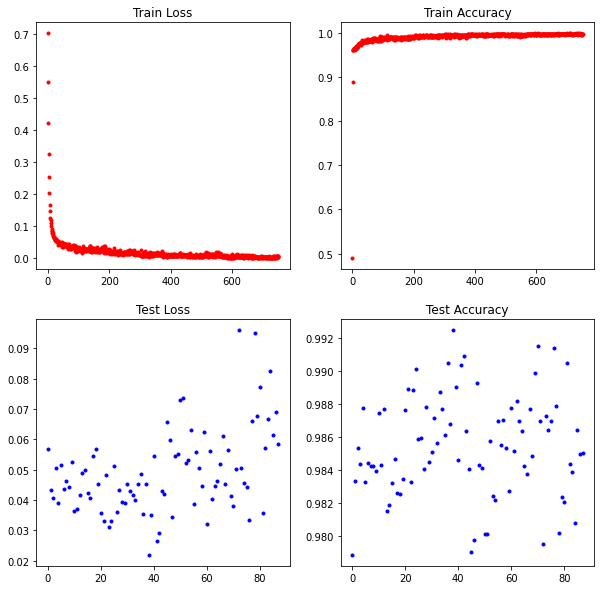

In [37]:
train_results = defaultdict(list)
train_iter, test_iter, best_acc = 0,0,0
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10, 10))
ax1.set_title('Train Loss')
ax2.set_title('Train Accuracy')
ax3.set_title('Test Loss')
ax4.set_title('Test Accuracy')

f1_scores = defaultdict(list)
for i in trange(params["epochs"], desc='Epochs'):
    print("Epoch ",i)
    ## Train Phase
    #Model switches to train phase
    model.train() 
    
    all_outputs = []
    all_targets = []
    # Running through all mini batches in the dataset
    count, loss_val, correct, total = train_iter, 0, 0, 0
    for img_data, target in tqdm(train_loader, desc='Training'):    
        img_data, target = img_data.to(device), target.to(device)
        
        output = model(img_data) #FWD prop

        loss = criterion(output, target) #Cross entropy loss
        c_loss = loss.data.item()
        ax1.plot(count, c_loss, 'r.')
        loss_val += c_loss

        optimizer.zero_grad() #Zero out any cached gradients
        loss.backward() #Backward pass
        optimizer.step() #Update the weights

        total_batch = (target.size(0) * target.size(1))
        total += total_batch
        output_data = torch.sigmoid(output)>=0.5
        target_data = (target==1.0)
        for arr1,arr2 in zip(output_data, target_data):
            all_outputs.append(list(arr1.cpu().numpy()))
            all_targets.append(list(arr2.cpu().numpy()))
        c_acc = torch.sum((output_data == target_data.to(device)).to(torch.float)).item()
        ax2.plot(count, c_acc/total_batch, 'r.')
        correct += c_acc
        count +=1
        
    all_outputs = np.array(all_outputs)
    all_targets = np.array(all_targets)
    f1score_samples = f1_score(y_true=all_targets, y_pred=all_outputs, average='samples')
    f1score_macro = f1_score(y_true=all_targets, y_pred=all_outputs, average='macro')
    f1score_weighted = f1_score(y_true=all_targets, y_pred=all_outputs, average='weighted')
    recall = recall_score(y_true=all_targets, y_pred=all_outputs, average='samples')
    prec = precision_score(y_true=all_targets, y_pred=all_outputs, average='samples')
    hamming = hamming_score(y_true=all_targets, y_pred=all_outputs)
    
    f1_scores["samples_train"].append(f1score_samples)
    f1_scores["macro_train"].append(f1score_macro)
    f1_scores["weighted_train"].append(f1score_weighted)
    f1_scores["hamming_train"].append(hamming)
    
    train_loss_val, train_iter, train_acc = loss_val/len(train_loader.dataset), count, correct/float(total)
    
    print("Training loss: ", train_loss_val, " train acc: ",train_acc)    
    ## Test Phase
    
    #Model switches to test phase
    model.eval()
    
    all_outputs = []
    all_targets = []
    #Running through all mini batches in the dataset
    count, correct, total, lost_val = test_iter, 0, 0, 0
    for img_data, target in tqdm(val_loader, desc='Testing'):
        img_data, target = img_data.to(device), target.to(device)
        output = model(img_data)
        loss = criterion(output, target) #Cross entropy loss
        c_loss = loss.data.item()
        ax3.plot(count, c_loss, 'b.')
        loss_val += c_loss
        #Compute accuracy
        #predicted = output.data.max(1)[1] #get index of max
        total_batch = (target.size(0) * target.size(1))
        total += total_batch
        output_data = torch.sigmoid(output)>=0.5
        target_data = (target==1.0)
        #print("Predictions: ", output_data)
        #print("Actual: ", target_data)
        for arr1,arr2 in zip(output_data, target_data):
            all_outputs.append(list(arr1.cpu().numpy()))
            all_targets.append(list(arr2.cpu().numpy()))
        c_acc = torch.sum((output_data == target_data.to(device)).to(torch.float)).item()
        ax4.plot(count, c_acc/total_batch, 'b.')
        correct += c_acc
        count += 1
    
    #print("Outputs: ", len(all_outputs), " x ", len(all_outputs[0]))
    #print("Targets: ", len(all_targets), " x ", len(all_targets[0]))
    
    #F1 Score
    all_outputs = np.array(all_outputs)
    all_targets = np.array(all_targets)
    f1score_samples = f1_score(y_true=all_targets, y_pred=all_outputs, average='samples')
    f1score_macro = f1_score(y_true=all_targets, y_pred=all_outputs, average='macro')
    f1score_weighted = f1_score(y_true=all_targets, y_pred=all_outputs, average='weighted')
    recall = recall_score(y_true=all_targets, y_pred=all_outputs, average='samples')
    prec = precision_score(y_true=all_targets, y_pred=all_outputs, average='samples')
    hamming = hamming_score(y_true=all_targets, y_pred=all_outputs)
    
    f1_scores["samples_test"].append(f1score_samples)
    f1_scores["macro_test"].append(f1score_macro)
    f1_scores["weighted_test"].append(f1score_weighted)
    f1_scores["hamming_test"].append(hamming)
    
    #Accuracy over entire dataset
    test_acc, test_iter, test_loss_val = correct/float(total), count, loss_val/len(test_loader.dataset)
    print("Test set accuracy: ",test_acc)
    print("f1_scores", f1_scores)
    train_results['epoch'].append(i)
    train_results['train_loss'].append(train_loss_val)
    train_results['train_acc'].append(train_acc)
    train_results['train_iter'].append(train_iter)
    
    train_results['test_loss'].append(test_loss_val)
    train_results['test_acc'].append(test_acc)
    train_results['test_iter'].append(test_iter)
    
    #Save model with best accuracy
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_model.pth') 
fig.savefig('train_curves.png')

#***Evaluation***